# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [1]:
import numpy as np
import os
from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

The code below can be compacted with the function ```create_truth```
```
  
from essentials.create import create_truth
truth = create_truth(filename, t_start, t_stop, Nt_obs, std_obs, noise_type='gauss', post_processed=True)
```

The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, t_obs=t_obs, y_obs=y_obs, 
     dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

In [2]:
ER = 0.5625
filename = data_folder + 'annular/ER_{}'.format(ER)

# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

i0, i1 = [np.argmin(abs(t_true - ti)) for ti in [3, 7]]
y_true, y_raw, t_true = [xx[i0:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Select the observations time-window
t_start = 2. * Annular.t_transient
t_stop = t_start + Annular.t_CR * 10
Nt_obs = 35

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]



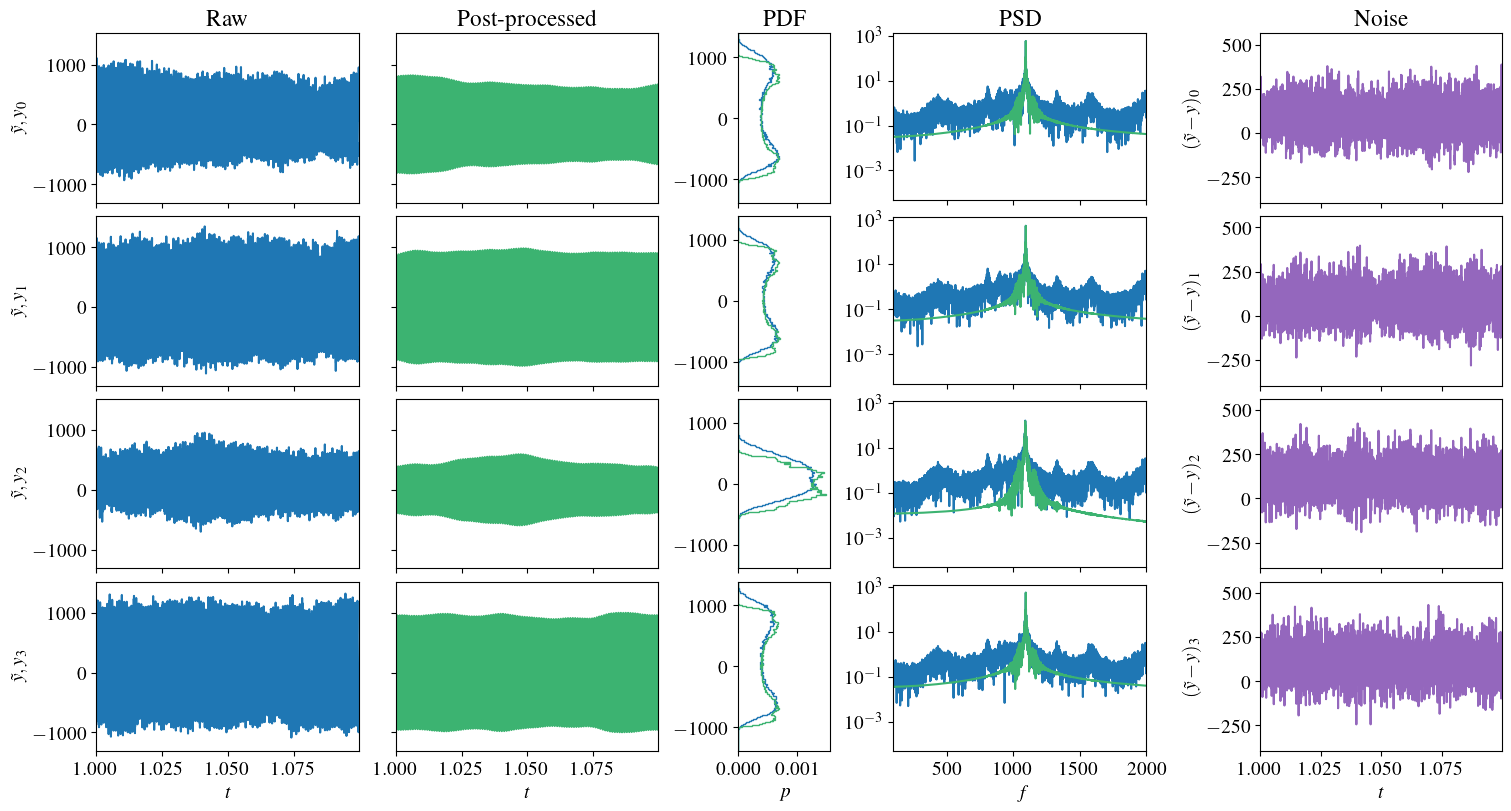

In [3]:
from essentials.plotResults import plot_truth
plot_truth(y_true=y_true, y_raw=y_raw, t=t_true, t_obs=t_obs, y_obs=y_obs, dt=dt_t)

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [4]:
alpha0 = dict(nu=(5., 40.),
              c2beta=(10, 50),
              kappa=(1.E-4, 1.3E-4),
              # epsilon=(0.0001, 0.03),
              omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
              # theta_b=(0.5, 0.7),
              # theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.0,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)



Visualize ensemble initialization

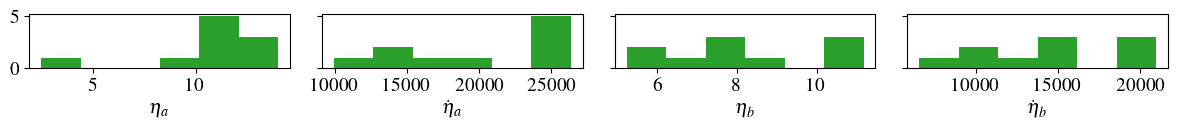

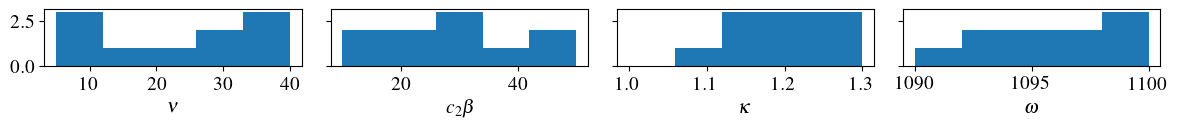

In [5]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [6]:
from essentials.create import create_bias_training_dataset

ensemble_no_bias = ensemble.copy()
ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=5,
                    t_train=ensemble.t_CR * 10,
                    t_test=ensemble.t_CR * 2,
                    t_val=ensemble.t_CR * 2,
                    # Training data generation options
                    augment_data=True,
                    bayesian_update=False,
                    biased_observations=True,
                    seed_W=0,
                    L=10,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16, 1e-12, 1e-9]
                    )
ensemble_ESN.init_bias(**train_params)


In [7]:
print(ensemble_ESN.bias.N_dim_in,
      ensemble_ESN.bias.N_dim, 
      ensemble_ESN.bias.observed_idx,
      ensemble_ESN.bias.bias_idx)

8 8 [0 1 2 3 4 5 6 7] []


|
**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [8]:
train_data = create_bias_training_dataset(y_raw, y_true, ensemble_ESN, **train_params)

Visualize training data


In [9]:
#TODO

print(train_data['data'].shape)

(30, 11269, 8)



**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

In [10]:
ensemble_ESN.bias.train_bias_model(**train_data)

sparsity =  0.9387755102040817
rho =  1.1112487908100046

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 


ValueError: could not broadcast input array from shape (8,1) into shape (4,1)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from essentials.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

In [ ]:
ensemble_ESN.bias.t_init = t_obs[0] - 2 * Nt_obs * dt_t

i1 = np.argmin(abs(ensemble_ESN.bias.t_init - t_true))
i0 = i1 - ensemble_ESN.bias.N_wash  * ensemble_ESN.bias.upsample 

wash_obs = y_raw[i0:i1 + 1:ensemble_ESN.bias.upsample]
wash_t = t_true[i0:i1 + 1:ensemble_ESN.bias.upsample]


## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [ ]:
from essentials.DA import dataAssimilation

DA_kwargs = dict(y_obs=y_obs, t_obs=t_obs, std_obs=0.1, wash_obs=wash_obs, wash_t=wash_t)

ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 1.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = t_obs[0]
    ens.inflation = 1.01
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 2
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens


In [ ]:
from essentials.plotResults import print_parameter_results

truth_params = dict()
for param in Annular.params:
    if param == 'nu':
        truth_params[param] = Annular.nu_from_ER(ER)
    elif param == 'c2beta':
        truth_params[param] = Annular.c2beta_from_ER(ER)
    else:
        truth_params[param] = Annular.defaults[param]

print_parameter_results(out, true_values=truth_params)
            

In [ ]:
from essentials.plotResults import plot_timeseries, plot_parameters


truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t,
             wash_t=wash_t, wash_obs=wash_obs)
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

window = (truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR*2)
plot_states_PDF(out, truth, nbins=20, window=window)
plot_RMS_pdf(out, truth, nbins=20)


for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plot_parameters(filter_ens, truth)

In [ ]:
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf
import matplotlib.pyplot as plt
from essentials.Util import interpolate
window = (truth['t_obs'][-1], truth['t'][-1])


print(window
      )

plot_states_PDF(out, truth, nbins=10, window=None)
plot_RMS_pdf(out, truth, nbins=10)

# TODO: Plot parameter histogram